# Poker AI Setup

## Imports

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pokerenv.obs_indices as indices
from pokerenv.table import Table
from treys import Deck, Evaluator, Card
from pokerenv.common import GameState, PlayerState, PlayerAction, TablePosition, Action, action_list
from pokerenv.player import Player
from pokerenv.utils import pretty_print_hand, approx_gt, approx_lte
import types
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import gym
import math
import time


## Create enviorment

In [104]:
class ModifiedTable(Table):
    def __init__(self, n_players, player_names=None, track_single_player=False, stack_low=50, stack_high=200, hand_history_location='hands/', invalid_action_penalty=0):
        super().__init__(n_players, player_names, track_single_player, stack_low, stack_high, hand_history_location, invalid_action_penalty)
        
    def _int_to_str(card_int: int) -> str:
        rank_int = Card.get_rank_int(card_int)
        suit_int = Card.get_suit_int(card_int)
        return Card.STR_RANKS[rank_int] + Card.INT_SUIT_TO_CHAR_SUIT[suit_int]
    
    def _get_rank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 8) & 0xF
        else:
            return (card_int[0] >> 8) & 0xF
        
    def _get_suit_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 12) & 0xF
        else:
            return (card_int[0] >> 12) & 0xF
        
    def _get_bitrank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 16) & 0x1FFF
        else:
            return (card_int[0] >> 16) & 0x1FFF

    def _get_prime(card_int: int) -> int:
        if card_int is int:
            return card_int & 0x3F
        else:
            return card_int[0] & 0x3F

    def _street_transition(self, transition_to_end=False):
            transitioned = False
            if self.street == GameState.PREFLOP:
                self.cards = self.deck.draw(3)
                self._write_event("*** FLOP *** [%s %s %s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2])))
                self.street = GameState.FLOP
                transitioned = True
            if self.street == GameState.FLOP and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** TURN *** [%s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3])))
                self.street = GameState.TURN
                transitioned = True
            if self.street == GameState.TURN and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** RIVER *** [%s %s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3]),
                                Card.int_to_str(self.cards[4])))
                self.street = GameState.RIVER
                transitioned = True
            if self.street == GameState.RIVER and (not transitioned or transition_to_end):
                if not self.hand_is_over:
                    if self.hand_history_enabled:
                        self._write_show_down()
                self.hand_is_over = True
            self.street_finished = False
            self.last_bet_placed_by = None
            self.first_to_act = None
            self.bet_to_match = 0
            self.minimum_raise = 0
            for player in self.players:
                player.finish_street()

    def step(self, action: Action):
        BB = 5
        self.current_player_i = self.next_player_i
        player = self.players[self.current_player_i]
        self.current_turn += 1

        if (player.all_in or player.state is not PlayerState.ACTIVE) and not self.hand_is_over:
            raise Exception("A player who is inactive or all-in was allowed to act")
        if self.first_to_act is None:
            self.first_to_act = player

        # Apply the player action
        if not (self.hand_is_over or self.street_finished):
            valid_actions = self._get_valid_actions(player)
            if not self._is_action_valid(player, action, valid_actions):
                player.punish_invalid_action()
            elif action.action_type is PlayerAction.FOLD:
                player.fold()
                self.active_players -= 1
                self._write_event("%s: folds" % player.name)
            elif action.action_type is PlayerAction.CHECK:
                player.check()
                self._write_event("%s: checks" % player.name)
            elif action.action_type is PlayerAction.CALL:
                call_size = player.call(self.bet_to_match)
                self.pot += call_size
                if player.all_in:
                    self._write_event("%s: calls $%.2f and is all-in" % (player.name, call_size * BB))
                else:
                    self._write_event("%s: calls $%.2f" % (player.name, call_size * BB))
            elif action.action_type is PlayerAction.BET:
                previous_bet_this_street = player.bet_this_street
                actual_bet_size = player.bet(np.round(action.bet_amount, 2))
                self.pot += actual_bet_size
                if self.bet_to_match == 0:
                    if player.all_in:
                        self._write_event("%s: bets $%.2f and is all-in" % (player.name, actual_bet_size * BB))
                    else:
                        self._write_event("%s: bets $%.2f" % (player.name, actual_bet_size * BB))
                else:
                    if player.all_in:
                        self._write_event("%s: raises $%.2f to $%.2f and is all-in" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                    else:
                        self._write_event("%s: raises $%.2f to $%.2f" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                self._change_bet_to_match(actual_bet_size + previous_bet_this_street)
                self.last_bet_placed_by = player
            else:
                raise Exception("Error when parsing action, make sure player action_type is PlayerAction and not int")

            should_transition_to_end = False
            players_with_actions = [p for p in self.players if p.state is PlayerState.ACTIVE if not p.all_in]
            players_who_should_act = [p for p in players_with_actions if (not p.acted_this_street or p.bet_this_street != self.bet_to_match)]

            # If the game is over, or the betting street is finished, progress the game state
            if len(players_with_actions) < 2 and len(players_who_should_act) == 0:
                amount = 0
                # If all active players are all-in, transition to the end, allowing no actions in the remaining streets
                if self.active_players > 1:
                    biggest_bet_call = max(
                        [p.bet_this_street for p in self.players
                            if p.state is PlayerState.ACTIVE if p is not self.last_bet_placed_by]
                    )
                    last_bet_this_street = 0
                    if self.last_bet_placed_by is not None:
                        last_bet_this_street = self.last_bet_placed_by.bet_this_street
                    if biggest_bet_call < last_bet_this_street:
                        amount = last_bet_this_street - biggest_bet_call
                    should_transition_to_end = True
                # If everyone else has folded, end the hand
                else:
                    self.hand_is_over = True
                    amount = self.minimum_raise
                # If there are uncalled bets, return them to the player who placed them
                if amount > 0:
                    self.pot -= amount
                    self.last_bet_placed_by.stack += amount
                    self.last_bet_placed_by.money_in_pot -= amount
                    self.last_bet_placed_by.bet_this_street -= amount
                    self._write_event(
                        "Uncalled bet ($%.2f) returned to %s" % (amount * BB, self.last_bet_placed_by.name)
                    )
                if should_transition_to_end:
                    self._street_transition(transition_to_end=True)
            # If the betting street is still active, choose next player to act
            else:
                active_players_after = [i for i in range(self.n_players) if i > self.current_player_i if
                                        self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                active_players_before = [i for i in range(self.n_players) if i <= self.current_player_i if
                                            self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                if len(active_players_after) > 0:
                    self.next_player_i = min(active_players_after)
                else:
                    self.next_player_i = min(active_players_before)
                next_player = self.players[self.next_player_i]
                if self.last_bet_placed_by is next_player or (self.first_to_act is next_player and self.last_bet_placed_by is None):
                    self.street_finished = True
                    if len(active_players_before) > 0:
                        self.next_player_i = min(active_players_before)

        if self.street_finished and not self.hand_is_over:
            self._street_transition()

        obs = np.zeros(self.observation_space.shape[0]) if self.hand_is_over else self._get_observation(self.players[self.next_player_i])
        rewards = np.asarray([player.get_reward() for player in sorted(self.players)])
        if self.hand_is_over:
            self._distribute_pot()
            self._finish_hand()
            
        return obs, rewards, self.hand_is_over, {}

In [105]:
# Create the enviorment:
def createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player=False):
    table = ModifiedTable(active_players, 
                player_names=player_names,
                track_single_player=track_single_player,
                stack_low=low_stack_bbs,
                stack_high=high_stack_bbs,
                hand_history_location=hand_history_location,
                invalid_action_penalty=invalid_action_penalty
    )
    table.seed(1)
    return table
            

## Env Modifications

## Learning Loop

In [106]:
def learningLoop(table, agents, active_players, n_iterations):
    iteration = 1
    playerWinnings = [[0 for player in table.players]]
    while True:
        if iteration % 50 == 0:
            table.hand_history_enabled = True
        table.n_players = active_players
        obs = table.reset()
        for agent in agents:
            agent.reset()
        acting_player = int(obs[indices.ACTING_PLAYER])
        while True:
            action = agents[acting_player].get_action(obs)
            obs, reward, done, _ = table.step(action)
            if  done:
                # Distribute final rewards
                for i in range(active_players):
                    agents[i].rewards.append(reward[i])
                break
            else:
                # This step can be skipped unless invalid action penalty is enabled, 
                # since we only get a reward when the pot is distributed, and the done flag is set
                agents[acting_player].rewards.append(reward[acting_player])
                acting_player = int(obs[indices.ACTING_PLAYER])
        iteration += 1
        playerWinnings.append([player.winnings for player in table.players])
        table.hand_history_enabled = False
        
        if iteration >= n_iterations:
            break
    
    return playerWinnings

# Agents

## Random Agent

In [107]:
# Agent that makes random actions
class RandomAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        chosen_action = PlayerAction(np.random.choice(valid_actions))
        bet_size = 0
        if chosen_action is PlayerAction.BET:
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Fold Agent

In [108]:
# Agent that always folds
class FoldAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Determined Agent

In [109]:
# Agent that never folds
class DeterminedAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.CALL
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Aggressive agent

In [110]:
# Agent that always raises
class AggressiveAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.BET
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, valid_bet_high)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    

## Chance agent

In [111]:
# Agent that uses encoded hand values to make decisions
class ValueAgent:
    def __init__(self, value_model):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.value_model = value_model

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        hand_value = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        bet_value = self.value_model.predict(np.array([[hand_value, pot_size]]))[0][0]
        
        if bet_value > 0.5:
            chosen_action = PlayerAction.BET
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        elif valid_bet_high == 0.0:
            chosen_action = PlayerAction.CALL
        else:
            chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## REgression to RElative REward Based RL Agent

In [112]:
class REBELAgent:
    def __init__(self, eta=0.1):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.scaler = StandardScaler()
        self.regressor = SGDRegressor()  # Regression model for action-value scores
        self.eta = eta  # Learning rate for policy updates

        # Initialize regressor with dummy data
        dummy_X = np.zeros((1, 63))  # Replace 63 with the correct feature size
        dummy_y = [0]
        self.regressor.partial_fit(dummy_X, dummy_y)

    def get_action(self, observation):
        self.observations.append(observation)

        # Get valid actions
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_action_types = [action_list[i] for i in valid_actions]  # Map to PlayerAction

        # Compute scores for each valid action
        action_scores = []
        for action_type in valid_action_types:
            encoded_action = self._encode_action(observation, Action(action_type, 0))
            action_scores.append(self.regressor.predict([encoded_action])[0])

        # Apply softmax to compute probabilities
        action_probs = self._softmax(action_scores)

        # Sample an action based on probabilities
        chosen_action_idx = np.random.choice(len(valid_action_types), p=action_probs)
        chosen_action = valid_action_types[chosen_action_idx]  # Use PlayerAction enum

        # Determine bet size if the chosen action is a bet
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        table_action = Action(chosen_action, bet_size)  # Use PlayerAction
        self.actions.append(table_action)
        return table_action

    def _softmax(self, scores):
        exp_scores = np.exp(scores - np.max(scores))  # Subtract max for numerical stability
        return exp_scores / np.sum(exp_scores)

    def update_policy(self):
        X = []
        y = []

        for obs, action in zip(self.observations, self.actions):
            action_features = self._encode_action(obs, action)
            reward = self._get_reward(obs, action)
            X.append(action_features)
            y.append(reward)

        X = self.scaler.fit_transform(X)
        self.regressor.partial_fit(X, y)

    def _encode_action(self, observation, action):
        action_vector = np.zeros(len(action_list))
        action_vector[action.action_type.value] = 1  # Use the value of PlayerAction
        bet_feature = np.array([action.bet_amount])
        return np.concatenate([observation, action_vector, bet_feature])

    def _get_reward(self, observation, action):
        return 0.0

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []


# Run Throughs

## Rebel vs ineffective agents

In [113]:
active_players = 6
agents = [REBELAgent(), RandomAgent(), FoldAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = True 
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(1)


In [114]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

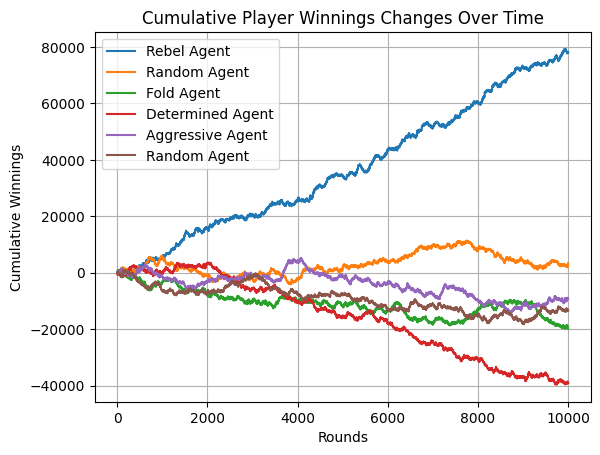

In [115]:
players = ["Rebel Agent", "Random Agent", "Fold Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 2 Rebels vs Variety

In [117]:
active_players = 6
agents = [REBELAgent(), REBELAgent(), RandomAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = True 
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(1)


In [119]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

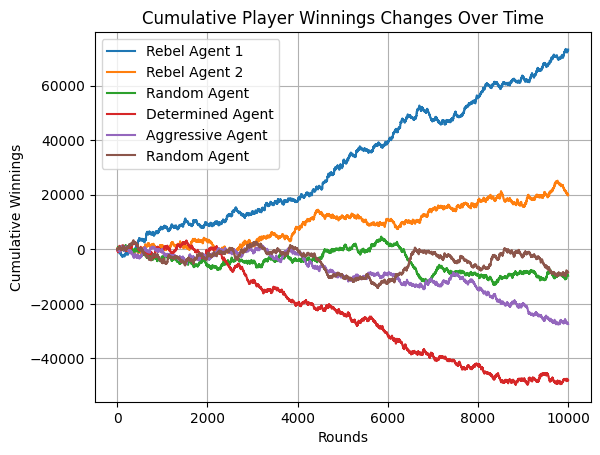

In [120]:
players = ["Rebel Agent 1", "Rebel Agent 2", "Random Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()